In [51]:
# Import the libraries
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis, zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

## Data Import

In [2]:
# Import the dataset and verify it loaded correctly
housing_df = pd.read_csv("melb_data.csv")

housing_df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


## Data Cleaning

In [3]:
# We only want to focus on houses and townhouses
print(housing_df['Type'].unique())
housing_df.loc[(housing_df['Type']=='h') | (housing_df['Type']=='t'),:]
print(f"After removing apartments (housing type 'u'), we have {housing_df.shape[0]} rows and {housing_df.shape[1]} columns.")

['h' 'u' 't']
After removing apartments (housing type 'u'), we have 13580 rows and 21 columns.


In [4]:
# Fix the misspelled columns
housing_df = housing_df.rename(columns={'Lattitude': 'Latitude','Longtitude': 'Longitude'})

In [5]:
# Get the range of dates
print(housing_df['Date'].tail())
print("We can see that the date range is in the format 'DD/MM/YY'")
print(f"The date range is: {housing_df['Date'].min()}-{housing_df['Date'].max()}")

13575    26/08/2017
13576    26/08/2017
13577    26/08/2017
13578    26/08/2017
13579    26/08/2017
Name: Date, dtype: object
We can see that the date range is in the format 'DD/MM/YY'
The date range is: 1/07/2017-9/09/2017


In [6]:
# Now we will fix the data range and change it to the American standard format

# Create a new copy of the dataset to modify
housing_cleaned = housing_df.copy()
# Adjust the date column to American format MM/DD/YY
housing_cleaned.loc[:,'Date'] = pd.to_datetime(housing_cleaned.loc[:,'Date'], format="%d/%m/%Y")
# Print the date range
print(f" The date range is: {housing_cleaned['Date'].min()} - {housing_cleaned['Date'].max()}")

 The date range is: 2016-01-28 00:00:00 - 2017-09-23 00:00:00


### Remove Missing Values

In [7]:
# Let's check for missing values
housing_cleaned.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Latitude            0
Longitude           0
Regionname          0
Propertycount       0
dtype: int64

In [8]:
# Now, we will drop columns that contain missing values
housing_dropped = housing_cleaned.copy()
housing_dropped = housing_dropped.drop(columns=['CouncilArea'])
housing_dropped = housing_dropped.dropna(axis=1)
housing_dropped.shape

(13580, 17)

In [9]:
# Now that we have dropped missing values, let's convert the Lat and Lon columns to an object type
cols_to_convert = ['Latitude', 'Longitude', 'Postcode']
for col in cols_to_convert:
    housing_dropped[col] = housing_dropped[col].astype('object')

In [10]:
housing_dropped.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode          object
Bedroom2         float64
Bathroom         float64
Landsize         float64
Latitude          object
Longitude         object
Regionname        object
Propertycount    float64
dtype: object

## Data Exploration

We will being our data exploration by looking at the distribution of Price and checking its skew and kurtosis.

<Axes: xlabel='Price', ylabel='Count'>

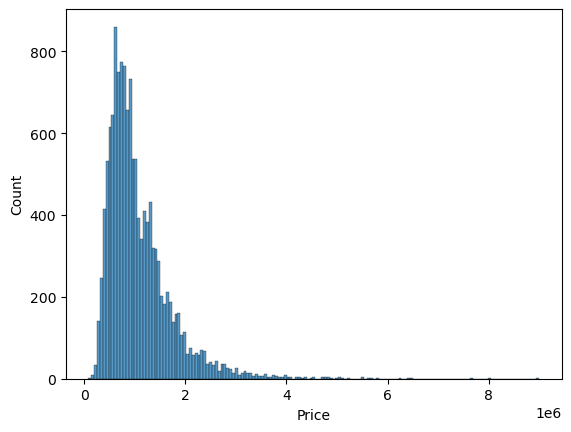

In [11]:
# Create a histogram plot of Price
sns.histplot(data=housing_dropped['Price'])

<Axes: ylabel='Price'>

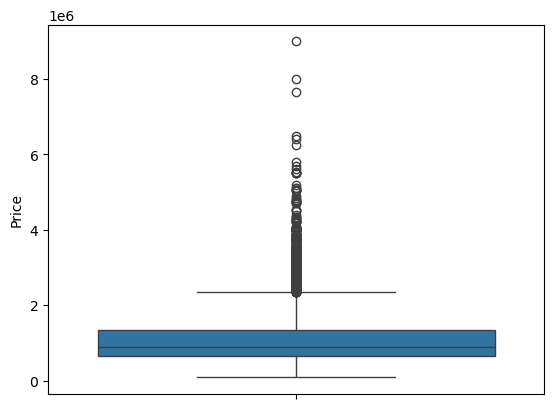

In [12]:
# Create a boxplot of Price
sns.boxplot(data=housing_dropped['Price'])

In [13]:
print(f"The skew of Price is: {housing_dropped['Price'].skew()}")
print(f"The kurtosis of Price is: {housing_dropped['Price'].kurtosis()}")

The skew of Price is: 2.239624312529873
The kurtosis of Price is: 9.87433888590604


## Price Analysis

We can see that the distribution of Price is positively skewed, with significant outliers in the right tail of the distribution. 

We will apply a logarithmic transform to help normalize the distribution.

In [14]:
# Let's apply a logarithmic transformation to the Price column
housing_dropped['Price_log'] = np.log(housing_dropped['Price'])

<Axes: xlabel='Price_log', ylabel='Count'>

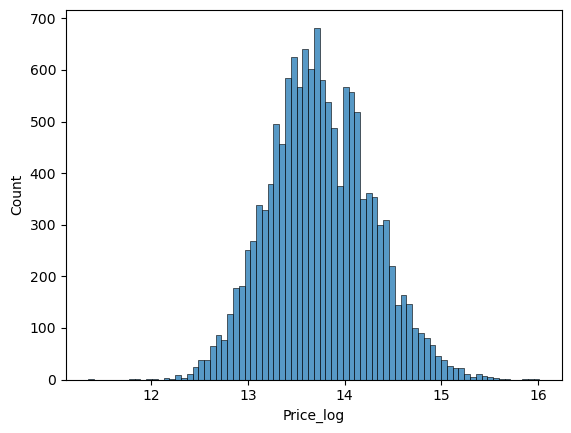

In [15]:
# Create a histogram plot of Price Log
sns.histplot(data=housing_dropped['Price_log'])

<Axes: ylabel='Price_log'>

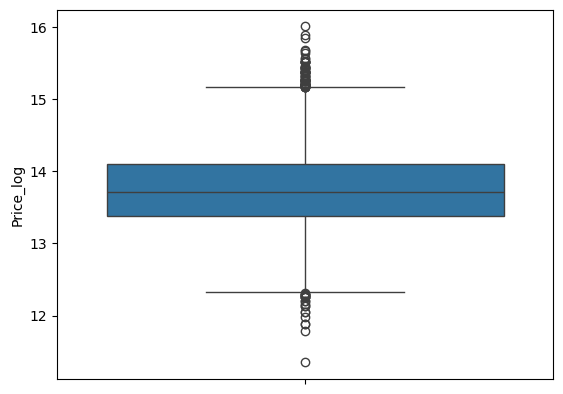

In [16]:
sns.boxplot(data=housing_dropped['Price_log'])

In [17]:
print(f"The skew of Price_log is: {housing_dropped['Price_log'].skew()} and the kurtosis is: {housing_dropped['Price_log'].kurtosis()}")

The skew of Price_log is: 0.18065988655954393 and the kurtosis is: 0.006205393358596378


In [18]:
housing_dropped.Suburb.value_counts()

Suburb
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Sandhurst           1
Bullengarook        1
Croydon South       1
Montrose            1
Monbulk             1
Name: count, Length: 314, dtype: int64

In [19]:
# Remove the outliers from Price using InterQuartile Range(IQR)
# Calculate the first quantile
Q1 = housing_dropped['Price'].quantile(0.25)
# Calculate the third quantile
Q3 = housing_dropped['Price'].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5

# Define the upper and lower bounds
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Remove outliers
housing_dropped_iqr = housing_dropped.loc[(housing_dropped['Price'] >= lower_bound) & (housing_dropped['Price'] <= upper_bound), :]
print(f"Shape of dataset after dropping outliers in Price: {housing_dropped.shape}")

Shape of dataset after dropping outliers in Price: (13580, 18)


## Visualizations

In [20]:
# Create a correlation matrix
numeric_cols = housing_dropped.select_dtypes(include=['float64']).columns
print(numeric_cols)
corr_matrix = housing_dropped.loc[:,numeric_cols].corr()
corr_matrix

Index(['Price', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize',
       'Propertycount', 'Price_log'],
      dtype='object')


,Price,Distance,Bedroom2,Bathroom,Landsize,Propertycount,Price_log
Price,1.000000,-0.162522,0.475951,0.467038,0.037507,-0.042153,0.927698
Distance,-0.162522,1.000000,0.295927,0.127155,0.025004,-0.054910,-0.153938
Bedroom2,0.475951,0.295927,1.000000,0.584685,0.025646,-0.081350,0.536716
Bathroom,0.467038,0.127155,0.584685,1.000000,0.037130,-0.052201,0.455706
Landsize,0.037507,0.025004,0.025646,0.037130,1.000000,-0.006854,0.033582
Propertycount,-0.042153,-0.054910,-0.081350,-0.052201,-0.006854,1.000000,-0.063999
Price_log,0.927698,-0.153938,0.536716,0.455706,0.033582,-0.063999,1.000000


<Axes: >

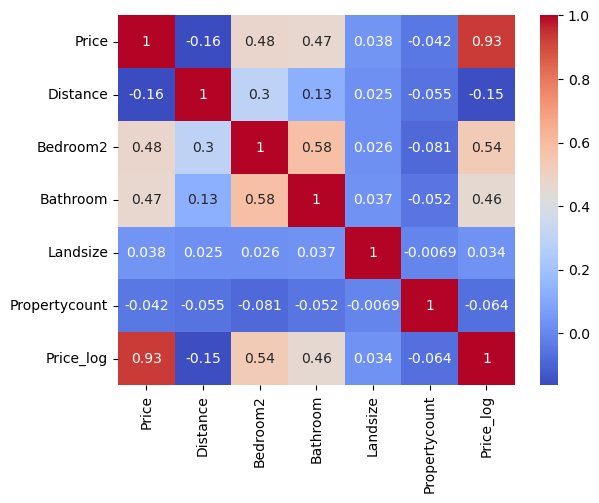

In [21]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

<Axes: xlabel='Price', ylabel='Count'>

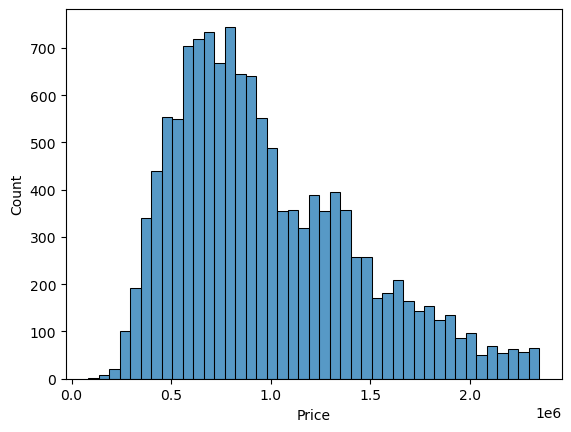

In [22]:
# Create a histogram plot of Price Log
sns.histplot(data=housing_dropped_iqr['Price'])

<Axes: ylabel='Price'>

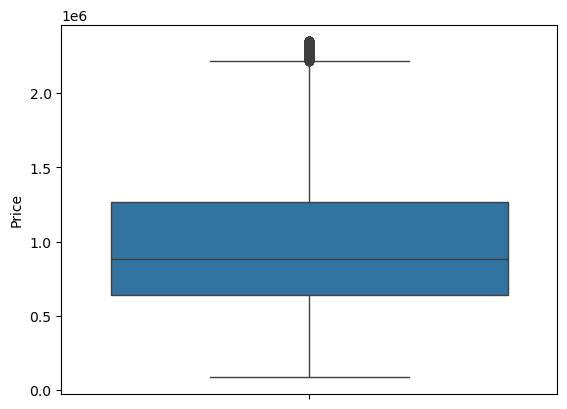

In [23]:
sns.boxplot(data=housing_dropped_iqr['Price'])

In [24]:
# Calculate the zscore
zscores = zscore(housing_dropped['Price'])

# Set the threshold for 3 standard deviations
threshold = 3 

housing_no_outliers = housing_dropped.loc[np.abs(zscores) < threshold].copy()
print(f"There are {housing_no_outliers.shape[0]} rows and {housing_no_outliers.shape[1]} columns.")

# Create a log of Price
housing_no_outliers['Price_log'] = np.log(housing_no_outliers['Price'])

There are 13348 rows and 18 columns.


<Axes: xlabel='Price', ylabel='Count'>

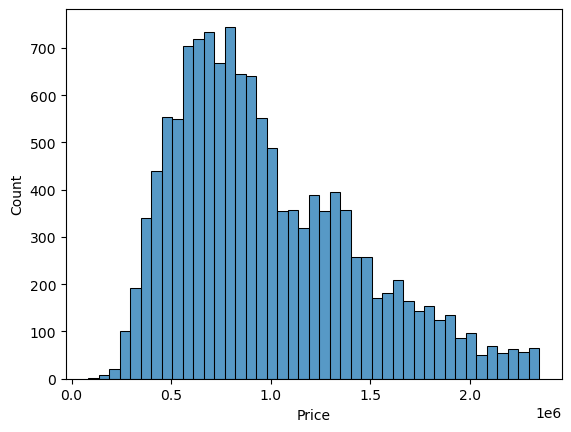

In [25]:
# Create a histplot
sns.histplot(data=housing_dropped_iqr['Price'])

<Axes: ylabel='Price'>

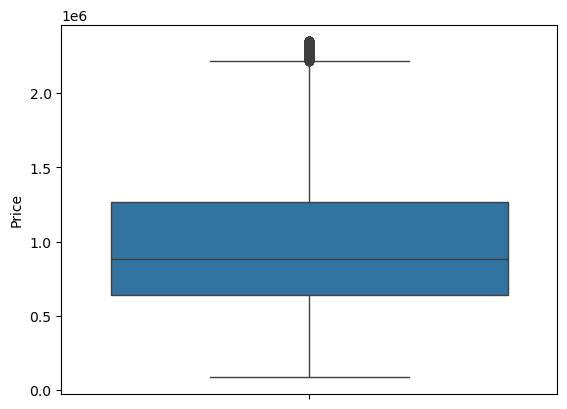

In [26]:
# Create a boxplot
sns.boxplot(data=housing_dropped_iqr['Price'])

In [27]:
# Let's apply a logarithmic transformation to the Price column
housing_dropped_iqr.loc[:,'Price_log'] = np.log(housing_dropped_iqr.loc[:,'Price'])

<Axes: xlabel='Price_log', ylabel='Count'>

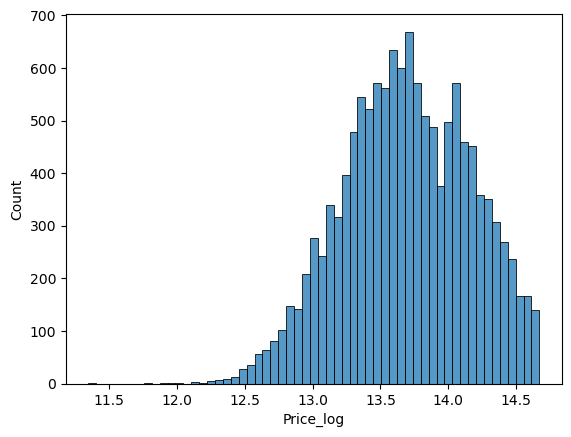

In [28]:
# Create a histplot
sns.histplot(data=housing_dropped_iqr['Price_log'])

<Axes: ylabel='Price_log'>

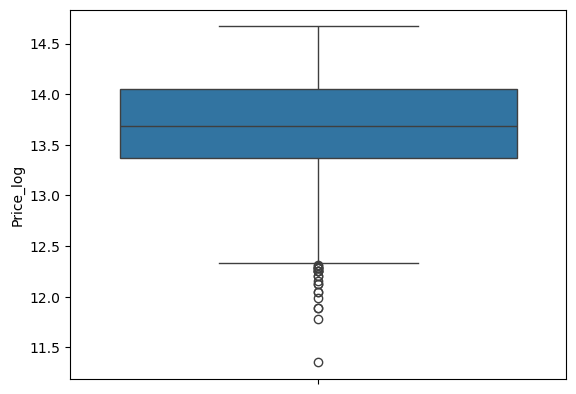

In [29]:
# Create a boxplot
sns.boxplot(data=housing_dropped_iqr['Price_log'])

In [30]:
# Create a bar plot of selling price by suburb
suburb_counts = housing_dropped_iqr['Suburb'].value_counts()

# Sort the suburbs by number of properties
suburb_counts

Suburb
Reservoir             359
Richmond              253
Bentleigh East        249
Preston               239
Brunswick             220
                     ... 
Beaconsfield Upper      1
Upwey                   1
Bullengarook            1
Bacchus Marsh           1
Monbulk                 1
Name: count, Length: 314, dtype: int64

In [31]:
housing_dropped_iqr.groupby('SellerG')['Price'].mean().head(20)

SellerG
@Realty         6.120000e+05
ASL             1.221375e+06
Abercromby's    1.390875e+06
Ace             7.200000e+05
Alexkarbon      8.278356e+05
Allens          1.106700e+06
Anderson        4.821000e+05
Appleby         7.960000e+05
Aquire          5.060000e+05
Area            7.700000e+05
Ascend          1.690050e+06
Ash             8.100000e+05
Asset           7.825000e+05
Assisi          8.260000e+05
Australian      7.985000e+05
Barlow          8.874828e+05
Barry           8.664751e+05
Bayside         9.100000e+05
Bekdon          1.078786e+06
Beller          8.043421e+05
Name: Price, dtype: float64

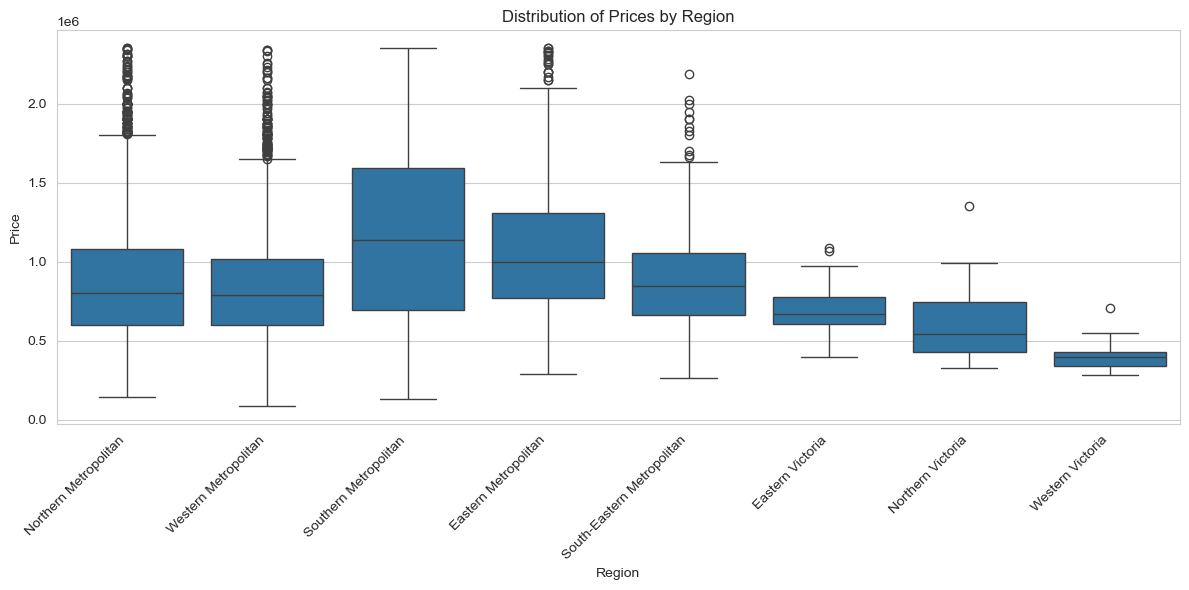

In [32]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.boxplot(data=housing_dropped_iqr, x='Regionname', y='Price')
plt.title('Distribution of Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
# Create a map to visualize the Regions
region_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Load GeoJSON data for region boundaries
region_boundaries = 'region_boundaries.geojson'

# Create a MarkerCluster Object and add it to the map
marker_cluster = MarkerCluster().add_to(region_map)

# Iterate over the regions and add markers for each region
for region, data in housing_dropped_iqr.groupby('Regionname'):
    mean_lat = data['Latitude'].mean()
    mean_lon = data['Longitude'].mean()

    # Create html object for popup
    html = f"<b>{region}</b><br>Mean Price: ${data['Price'].mean():,.2f}"
    
    # Add a marker for the region with popup showing region name and mean price
    popup = folium.Popup(IFrame(html, height=100, width=200), parse_html=True)
    folium.Marker(location=[mean_lat, mean_lon], popup=popup).add_to(marker_cluster)

# Display the map
region_map

In [34]:
# Create a map to visualize the Regions
region_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Load GeoJSON data for region boundaries
region_boundaries = 'region_boundaries.geojson'

# Add region boundaries to the map
with open(region_boundaries, 'r') as f:
    geojson_data = json.load(f)

for feature in geojson_data['features']:
    coordinates = feature['geometry']['coordinates'][0]  # Assuming the region is represented as a single polygon
    
    # Print the coordinates to debug
    print(coordinates)
    
    folium.Polygon(locations=coordinates, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(region_map)

# Display the map
region_map

[[145.135, -37.8151], [145.1215, -37.828], [145.1267, -37.8233], [145.1216, -37.8257], [145.1298, -37.8275], [145.1246, -37.8258], [145.1373, -37.8167], [145.1218, -37.8135], [145.1274, -37.8274], [145.1301, -37.8282], [145.1209, -37.827], [145.1319, -37.8287], [145.1272, -37.8285], [145.1276, -37.8235], [145.1281, -37.8247], [145.1262, -37.8143], [145.1319, -37.8244], [145.1354, -37.81800000000001], [145.1354, -37.8166], [145.1206, -37.8247], [145.121, -37.8279], [145.1289, -37.8273], [145.1281, -37.8261], [145.1248, -37.8264], [145.1242, -37.8274], [145.1269, -37.8246], [145.1195, -37.8283], [145.1355, -37.8154], [145.0862, -37.7608], [145.0994, -37.7628], [145.0957, -37.7657], [145.082, -37.7695], [145.0869, -37.7695], [145.0881, -37.7683], [145.0959, -37.7683], [145.09799999999996, -37.7729], [145.102, -37.7813], [145.0901, -37.7778], [145.099, -37.7689], [145.0889, -37.7582], [145.101, -37.779], [145.1033, -37.7724], [145.0871, -37.7697], [145.0853, -37.7607], [145.0913, -37.778],

## Model Creation

In [45]:
# Split the data into training and test sets
X = housing_dropped_iqr.drop(['Price', 'Price_log'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = housing_dropped_iqr['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Create a X and y variables for the linear regression
y_linear = housing_dropped_iqr['Price_log']
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X, y_linear, test_size=0.2, random_state=42)

# Create a standard scaler 
s_scaler = StandardScaler()

# Fit the scaler to the training data
X_train_scaled = s_scaler.fit_transform(X_train)

# Transform the test data 
X_test_scaled = s_scaler.transform(X_test)

In [ ]:
# Create a Linear Regression Model

linear_reg = LinearRegression()
linear_reg.fit(X_train_linear, y_train_linear)
y_pred_linear = linear_reg.predict(X_test_linear)
mse_linear = mean_squared_error(y_test_linear, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)
r2_linear = r2_score(y_test_linear, y_pred_linear)
linear_scores = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
print(f"Linear scores: MSE: {mse_linear}, RMSE: {rmse_linear}, MAE: {mae_linear}, R2: {r2_linear}")
linear_scores.loc[0] = ['Linear', mse_linear, rmse_linear, mae_linear, r2_linear]
linear_scores

In [49]:
# Create a Random Forest Model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rf_scores = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
rf_scores.loc[0] = ['Random Forest', mse_rf, rmse_rf, mae_rf, r2_rf]


Feature Importance for Random Forest:
Type_u                              0.208905
Regionname_Southern Metropolitan    0.182748
Distance                            0.146906
Landsize                            0.102221
Rooms                               0.065720
                                      ...   
Address_89 Pearson St               0.000000
Address_89 Raglan St                0.000000
Address_8B Myrtle St                0.000000
Address_8a Pines Gr                 0.000000
Latitude_-37.89807                  0.000000
Length: 26855, dtype: float64


,Model,MSE,RMSE,MAE,R2
0,Random Forest,4.008915e+10,200222.743416,141858.550709,0.808864


In [50]:
# Get feature importance for Random Forest
feature_importance_rf = pd.Series(random_forest.feature_importances_, index=X.columns)
feature_importance_rf = feature_importance_rf.sort_values(ascending=False)
print("Feature Importance for Random Forest:")
print(feature_importance_rf)
# Display the scores
rf_scores

Feature Importance for Random Forest:
Type_u                              0.208905
Regionname_Southern Metropolitan    0.182748
Distance                            0.146906
Landsize                            0.102221
Rooms                               0.065720
                                      ...   
Address_89 Pearson St               0.000000
Address_89 Raglan St                0.000000
Address_8B Myrtle St                0.000000
Address_8a Pines Gr                 0.000000
Latitude_-37.89807                  0.000000
Length: 26855, dtype: float64


,Model,MSE,RMSE,MAE,R2
0,Random Forest,4.008915e+10,200222.743416,141858.550709,0.808864


In [48]:
# Create a Decision Tree Model
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
dt_scores = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
dt_scores.loc[0] = ['Decision Tree', mse_dt, rmse_dt, mae_dt, r2_dt]
dt_scores

,Model,MSE,RMSE,MAE,R2
0,Decision Tree,6.228421e+10,249568.050072,176970.979954,0.703043


In [ ]:
linear_scores